# Statistical Analysis and Classification/Prediction Models
----

This notebook covers examples of some common statistical and machine learning models and techniques.  It does not teach the theory behind the models and techniques.  

We'll look at three modules:
* [`scipy.stats`](https://docs.scipy.org/doc/scipy-0.19.1/reference/tutorial/stats.html)
* [`statsmodels`](https://github.com/statsmodels/statsmodels): [documentation](http://www.statsmodels.org/stable/index.html)
* [`scikit-learn`](http://scikit-learn.org/stable/)

All of the packages come with the Anaconda distribution of Python, so most of you should already have them installed. 

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

/Users/christina/anaconda/envs/p3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Probability Distributions and Basic Tests

`scipy.stats` has objects for major probability distributions: https://docs.scipy.org/doc/scipy-0.19.1/reference/stats.html#module-scipy.stats

The distributions have similar functions and methods depending on the type of distribution (e.g. continuous, discrete)

In [2]:
from scipy.stats import expon

In [3]:
expon.stats(moments='mvsk') # mean, var, skew, kurt

(array(1.0), array(1.0), array(2.0), array(6.0))

Plot the pdf.  Get 100 evenly spaced values covering the range of 0 of the distribution probability to 99% (since 100% is at infinity)

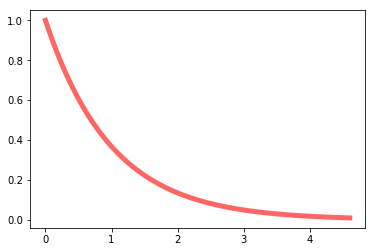

In [4]:
x = np.linspace(expon.ppf(0), expon.ppf(.99), 100) #ppf is percent point function
fig, ax = plt.subplots()
ax.plot(x, expon.pdf(x), 'r-', lw=5, alpha=0.6, label='expon pdf');

We can change the mean and standard deviation with the `loc` and `scale` parameters

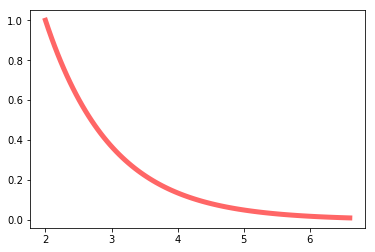

In [5]:
myloc = 2
myscale = 1
x = np.linspace(expon.ppf(0, myloc, myscale), expon.ppf(.99, myloc, myscale), 100) #ppf is percent point function
fig, ax = plt.subplots()
ax.plot(x, expon.pdf(x, myloc, myscale), 'r-', lw=5, alpha=0.6, label='expon pdf');

In [6]:
print(expon.mean(), expon.var())
print(expon.mean(2,2), expon.var(2, 2))

1.0 1.0
4.0 4.0


You can get random samples from the distributions:

In [7]:
expon.rvs(size=10)

array([ 2.94226666,  1.7408177 ,  0.40662093,  0.07023458,  0.03226823,
        3.55356513,  2.29459229,  2.01634783,  0.66197946,  0.25064677])

### Statistical Tests

There are methods for conducting t-tests.  See: [Student's t-distribution](https://en.wikipedia.org/wiki/Student%27s_t-distribution)

In [8]:
from scipy.stats import ttest_ind, norm
a = norm.rvs(size=100)
b = norm.rvs(.1, size=100)
ttest_ind(a, b)

Ttest_indResult(statistic=-0.53244310551658136, pvalue=0.59501613237435524)

Also methods for correlation that return the correlation coefficient and the two-tailed p-value on the test for no correlation; See [Pearson Correlation](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient)

(0.405725086182605, 2.8163313587906027e-05)

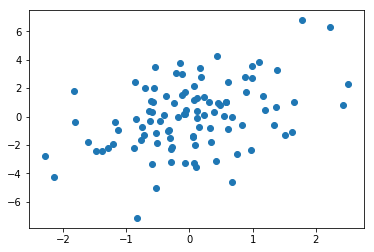

In [9]:
a = norm.rvs(size=100)
b = a + 2 * norm.rvs(size=100)
plt.scatter(a,b)
stats.pearsonr(a, b)

### Transforming Data

`scipy.stats` also includes methods for transforming data, like computing the [z-score](https://en.wikipedia.org/wiki/Standard_score) or converting data to ranks.

In [10]:
a = norm.rvs(2,5,size=20)
b = stats.zscore(a)
print(b.mean(), b.std())

-4.4408920985e-17 1.0


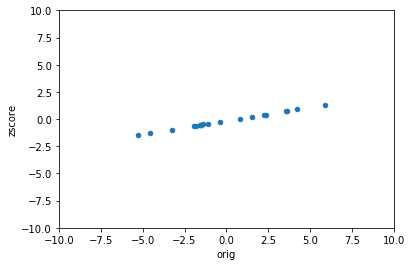

In [11]:
pd.DataFrame({'orig':a, 'zscore':b}).plot('orig','zscore',kind='scatter',
                                         xlim=(-10,10), ylim=(-10,10))

In [12]:
ranked = pd.DataFrame({"a":a, "rank":stats.rankdata(a)})
ranked.head(10)

,a,rank
0,-1.086752,10.0
1,2.224952,14.0
2,5.905641,19.0
3,-0.386226,11.0
4,3.552119,16.0
5,1.520450,13.0
6,-5.304381,1.0
7,4.213494,18.0
8,12.937415,20.0
9,-1.800560,5.0


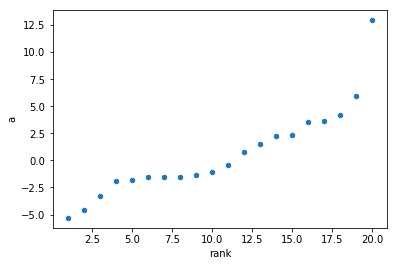

In [13]:
ranked.plot("rank", "a", kind="scatter")

### Missing Data

There are also functions for dealing with arrays with missing data (NumPy masked arrays) in `scipy.stats.mstats`.

## Regression-type Models

### `statsmodels`

`statmodels` includes many models for variations on linear regression.  It has an interface similar to R in many respects.

Let's start with some basics.

#### Get Data

We'll use a data set that's available in R.  `statsmodels` can read in data sets from R packages.

In [14]:
duncan_prestige = sm.datasets.get_rdataset("Duncan", "car") #first is name of data, second is package name
print(duncan_prestige.__doc__)

+----------+-------------------+
| Duncan   | R Documentation   |
+----------+-------------------+

Duncan's Occupational Prestige Data
-----------------------------------

Description
~~~~~~~~~~~

The ``Duncan`` data frame has 45 rows and 4 columns. Data on the
prestige and other characteristics of 45 U. S. occupations in 1950.

Usage
~~~~~

::

    Duncan

Format
~~~~~~

This data frame contains the following columns:

type
    Type of occupation. A factor with the following levels: ``prof``,
    professional and managerial; ``wc``, white-collar; ``bc``,
    blue-collar.

income
    Percent of males in occupation earning $3500 or more in 1950.

education
    Percent of males in occupation in 1950 who were high-school
    graduates.

prestige
    Percent of raters in NORC study rating occupation as excellent or
    good in prestige.

Source
~~~~~~

Duncan, O. D. (1961) A socioeconomic index for all occupations. In
Reiss, A. J., Jr. (Ed.) *Occupations and Social Status.* Free Press
[Ta

In [15]:
duncan_prestige.data.head() # data is in the .data attribute

,type,income,education,prestige
accountant,prof,62,86,82
pilot,prof,72,76,83
architect,prof,75,92,90
author,prof,55,90,76
chemist,prof,64,86,90


Let's look at the relationship between prestige and income to start.

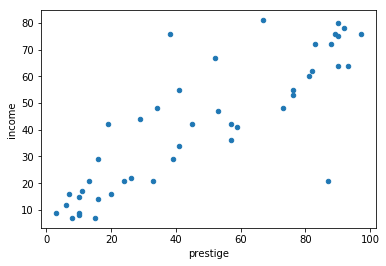

In [16]:
duncan_prestige.data.plot("prestige","income", kind="scatter")

#### OLS Linear Regression

Run an ordinary least squares regression for these two variables.  Exercises for NumPy also had you do this, but here we'll use `statsmodels`, which gives us a nice summary of the results.

Remember that we imported the models module as `smf` above.

`statsmodels` allows the forumla syntax that you'll also see in R:

```
y ~ x1 + x2
```

Or you could use NumPy arrays instead (2D array for independent variables and 1D for dependent variable)

In [17]:
results = smf.ols('income ~ prestige', data=duncan_prestige.data).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     101.3
Date:                Wed, 02 Aug 2017   Prob (F-statistic):           7.14e-13
Time:                        17:41:09   Log-Likelihood:                -179.93
No. Observations:                  45   AIC:                             363.9
Df Residuals:                      43   BIC:                             367.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.8840      3.678      2.959      0.0

This is a fairly strong relationship (for social science anyway).  But in the plot above, it looks like there might be something else going on in the data.  

We can use Seaborn to see if type of occupation might matter:

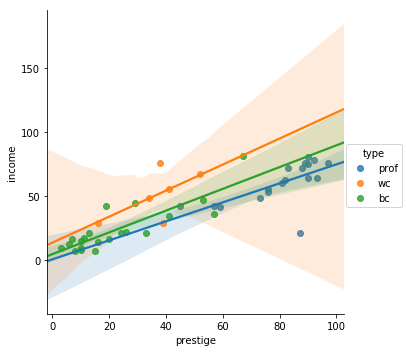

In [18]:
sns.lmplot(x="prestige", y="income", hue="type", data=duncan_prestige.data)

Looks like there may be different slopes and intercepts.  Let's revise the model to allow for that.  

To create an interaction term, use `*`.  It will automatically add in both variables by themselves, and the two variables multiplied by each other.  `statsmodels` will automatically convert categorical variables to individual indicators first (it will choose one category as the base).

In [19]:
results = smf.ols('income ~ prestige*type', data=duncan_prestige.data).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     28.35
Date:                Wed, 02 Aug 2017   Prob (F-statistic):           5.18e-12
Time:                        17:41:10   Log-Likelihood:                -172.66
No. Observations:                  45   AIC:                             357.3
Df Residuals:                      39   BIC:                             368.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 4.40

What about education?

In [20]:
results = smf.ols('income ~ prestige*type + education', data=duncan_prestige.data).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     23.60
Date:                Wed, 02 Aug 2017   Prob (F-statistic):           2.05e-11
Time:                        17:41:10   Log-Likelihood:                -172.22
No. Observations:                  45   AIC:                             358.4
Df Residuals:                      38   BIC:                             371.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 7.30

### scikit-learn

Let's do the same regression model as above, but with scikit-learn instead.  We'll have to construct the matrix of explanatory X variables ourselves first.

In [21]:
X = duncan_prestige.data[["prestige","education","type"]]
X = pd.get_dummies(X) # create dummy variables for type of profession
print(X.head())

            prestige  education  type_bc  type_prof  type_wc
accountant        82         86        0          1        0
pilot             83         76        0          1        0
architect         90         92        0          1        0
author            76         90        0          1        0
chemist           90         86        0          1        0


Create interaction terms

In [29]:
X['prestige-prof'] = X.prestige*X.type_prof
X['prestige-wc'] = X.prestige*X.type_wc
del X['type_bc'] ## blue collar will be our base category, so we don't need a column for it

Run the model.  We can get the coefficients, but there isn't a method for a nice summary of results.

Why no summary?  Scikit-learn is focused on machine learning models, where you mostly care about the predictions, not the statistics of the coefficients.

In [33]:
from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit(X[["type_prof","type_wc","prestige","prestige-prof","prestige-wc","education"]], duncan_prestige.data.income)
print(reg.coef_)
print(reg.intercept_)

[-3.51900651  9.76908888  0.88225837 -0.03807586  0.27394361 -0.14312955]
7.30597226396


Compare these to the results from `statsmodels` above.  They are the same.   Use `np.isclose()` because they may not be the same to full precision.  Remove the intercept from `results.params` before comparing.

In [51]:
np.isclose(reg.coef_,results.params[1:].tolist()) 

array([ True,  True,  True,  True,  True,  True], dtype=bool)